In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import sys
sys.path.append('../../')
import bemppUQ
import numpy as np
import bempp.api 
from bemppUQ.shapes import kite, perturbate
from bemppUQ.functions import tangential_trace, neumann_trace
from bemppUQ.utils.login import rescale
from bemppUQ.operators.maxwell import multitrace_identity, multitrace_operator, assemble_operators, evaluate_far_field, evaluate_far_field_sd
from bemppUQ.utils.login import rescale, gmres

from bempp.api.assembly.blocked_operator import \
        coefficients_of_grid_function_list, \
        projections_of_grid_function_list, \
        grid_function_list_from_coefficients


bempp.api.global_parameters.assembly.boundary_operator_assembly_type = 'dense'
restart = 100
maxiter = 100
tolerance = 1e-4


number_of_angles = 400
angles = np.pi * np.linspace(0, 2, number_of_angles)
far_field_points = np.array([np.cos(angles), np.sin(angles), np.zeros(number_of_angles)])
case = 'LF'

if case == 'LF':
    polarization = np.array([1.0 + 1j, 2.0, -1.0 - 1.0 / 3.0 * 1j])
    direction = np.array([1.0 / np.sqrt(14), 2.0 / np.sqrt(14), 3.0 / np.sqrt(14)], dtype='float64')

    eps_rel = 1.9
    mu_rel = 1.

    #k_ext = 1.047197551196598
    k_ext = 4
    k_int = k_ext * np.sqrt(eps_rel * mu_rel)

print("The exterior wavenumber is: {0}".format(k_ext))
print("The interior wavenumber is: {0}".format(k_int))

precision = 10
h = 2.0 * np.pi / (precision * k_int)
h = 1

def function(x, y, i, j):
    zx = 0
    zy = 0
    if i == 0:
        zx = np.sin(x * np.pi * 2)
    if i == 1:
        if x <= 0.25:
            zx = np.sin(x * np.pi * 4)
    if i == 2:
        if x > 0.25:
            zx = -np.sin(x * np.pi * 4)
    if i == 3:
        if x <= 0.5 / 3.:
            zx = np.sin(x * np.pi * 6)
    if i == 4:
        if x > 0.5 / 3. and x <= 1 / 3.:
            zx = -np.sin(x * np.pi * 6)
    if i ==5:
        if x > 1/3.:
            zx = np.sin(x * np.pi * 6)

    if j == 0:
        zy = np.sin(y * np.pi * 2)

    if j == 1:
        if y <= 0.25:
            zy = np.sin(y * np.pi * 4)

    if j == 2:
        if y > 0.25:
            zy = -np.sin(y * np.pi * 4)

    if j == 3:
        if y <= 0.5 / 3.:
            zy = np.sin(y * np.pi * 6)

    if j == 4:
        if y > 0.5 / 3. and y <= 1 / 3.:
            zy = -np.sin(y * np.pi * 6)
    if j == 5:
        if y > 1/3.:
            zy = np.sin(y * np.pi * 6)
    return zx * zy

def Phiz(point, n, domain_index, result):
    x, y, z = point

    res = 0j
    if z == 0.5 and (x <= 0.5) and (y <= 0.5):
        for ii in range(6):
            for jj in range(6):
                res += Random[ii,jj] * function(x, y, ii,jj)	
    result[0] = res

def perturbate(grid, t, kappa_pert=None):
    P1 = bempp.api.function_space(grid, 'P', 1)
    grid_funz = bempp.api.GridFunction(P1, fun = Phiz)
    elements = grid.leaf_view.elements
    vertices = grid.leaf_view.vertices
    normals = P1.global_dof_normals
    x, y, z = vertices
    
    vertices[2, :] = z + t * grid_funz.coefficients
    return bempp.api.grid_from_element_data(vertices, elements)
    

The exterior wavenumber is: 4
The interior wavenumber is: 5.513619500836088


In [2]:
#transmission_operators = assemble_operators(base_grid, k_int, k_ext, far_field_points)
#far_field, solution = evaluate_far_field(transmission_operators, eps_rel, mu_rel, k_ext, polarization, direction)
#far_field_p = evaluate_far_field_sd(base_grid, transmission_operators, eps_rel, mu_rel, k_int, k_ext, polarization, direction, solution, grid_fun)

def solver(grid):
    transmission_operators = assemble_operators(grid, k_int, k_ext, far_field_points, spaces='maxwell_primal', osrc=True)
    
    multitrace_int, multitrace_ext, osrc_int, osrc_ext, identity, electric_far, magnetic_far = transmission_operators

    rescaled_osrc_int_op = rescale(osrc_int, np.sqrt(eps_rel), np.sqrt(mu_rel))
    rescaled_int_op = rescale(multitrace_int, np.sqrt(eps_rel), np.sqrt(mu_rel))

    lhs_osrc = rescaled_osrc_int_op +osrc_ext
    lhs_op = rescaled_int_op + multitrace_ext
    rhs_op = .5 * identity - rescaled_int_op
    electric_incident = bempp.api.GridFunction(lhs_op.domain_spaces[0], fun=tangential_trace(k_ext, polarization, direction))
    magnetic_incident = bempp.api.GridFunction(lhs_op.domain_spaces[1], fun=neumann_trace(k_ext, polarization, direction))

    rhs = rhs_op * [electric_incident, magnetic_incident]
    b = projections_of_grid_function_list(rhs, lhs_op.dual_to_range_spaces)
    lhs_op_wf = lhs_op.weak_form()
    P = lhs_osrc.weak_form()
    A = P * lhs_op_wf
    f = P * b
    x_osrc, info, res, time = gmres(A, f, return_residuals=True, restart=restart, maxiter=maxiter, tol=tolerance)
    solution_osrc = grid_function_list_from_coefficients(x_osrc, lhs_op.domain_spaces)
    far_field_osrc = 4. * np.pi * ( -electric_far * solution_osrc[1] - magnetic_far * solution_osrc[0])
    return far_field_osrc



In [9]:
grid = bempp.api.shapes.reentrant_cube(h=h)

print(grid.leaf_view.entity_count(1) * 2, 'N')
FF = solver(grid)

cs = 10 * np.log10(4 * np.pi * np.sum(np.abs(FF)**2, axis=0))


198 N
iteration - 1 || residual - 0.483784114792 0.04720878601074219
iteration - 2 || residual - 0.325124952663 0.03669881820678711
iteration - 3 || residual - 0.221238937808 0.015119075775146484
iteration - 4 || residual - 0.152279811451 0.00774073600769043
iteration - 5 || residual - 0.0865143821396 0.008049249649047852
iteration - 6 || residual - 0.0587359031123 0.007906436920166016
iteration - 7 || residual - 0.0418589965725 0.027742862701416016
iteration - 8 || residual - 0.0226552667987 0.014587879180908203
iteration - 9 || residual - 0.0150095757551 0.0059053897857666016
iteration - 10 || residual - 0.00956435933163 0.031517744064331055
iteration - 11 || residual - 0.00618634808572 0.0050885677337646484
iteration - 12 || residual - 0.00399652548426 0.007486820220947266
iteration - 13 || residual - 0.00259218966404 0.0071964263916015625
iteration - 14 || residual - 0.00175783410829 0.015828847885131836
iteration - 15 || residual - 0.00116831911629 0.008783102035522461
iteration -

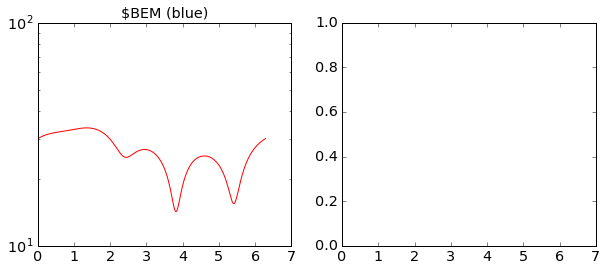

In [11]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.figsize'] = (10, 4) # Increase the figure size in the notebook
params = {'legend.fontsize': 'x-large', 'axes.labelsize': 'x-large', 'axes.titlesize': 'x-large',
         'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'}
plt.rcParams.update(params)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=False)

f0 = axes[0].semilogy(angles,cs,'-r')
axes[0].set_title('$BEM (blue)')

plt.show()